<a href="https://colab.research.google.com/github/rashmikaslikar/image_classification/blob/main/tu_ulm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import time
import datetime

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler, SequentialSampler
import torchvision.transforms as transforms

In [2]:
# Load the dataset
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

### Basic data insights

#### Data dimensions

In [3]:
train_data = train['X']
train_labels = train['y']

test_data = test['X']
test_labels = test['y']

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(32, 32, 3, 73257)
(73257, 1)
(32, 32, 3, 26032)
(26032, 1)


#### Distribution of the target metric

In [126]:
np.unique(train_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [127]:
np.unique(test_labels)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

To make the dataset easier to use for training machine learning models, we convert the label 10 to 0 so that the digit 0 is properly represented and aligns with typical digit classification frameworks, where class labels usually range from 0 to 9.

In [128]:
# Convert label 10 to 0, as it's used to represent the digit 0 in this dataset
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

In [129]:
train_labels

array([[1],
       [9],
       [2],
       ...,
       [1],
       [6],
       [9]], dtype=uint8)

In [130]:
def target_distribution(labels):
    plt.figure(figsize = (12, 8))
    unique_labels, counts = np.unique(labels, return_counts=True)

    # Define colors for each bar
    colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors  # Get 10 distinct colors

    # Create the bar plot with different colors for each bar
    plt.figure(figsize=(10, 6))
    bars = plt.bar(unique_labels, counts, color=colors)

<ipython-input-130-55e1aa3f45d3>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels)).colors  # Get 10 distinct colors


<Figure size 1200x800 with 0 Axes>

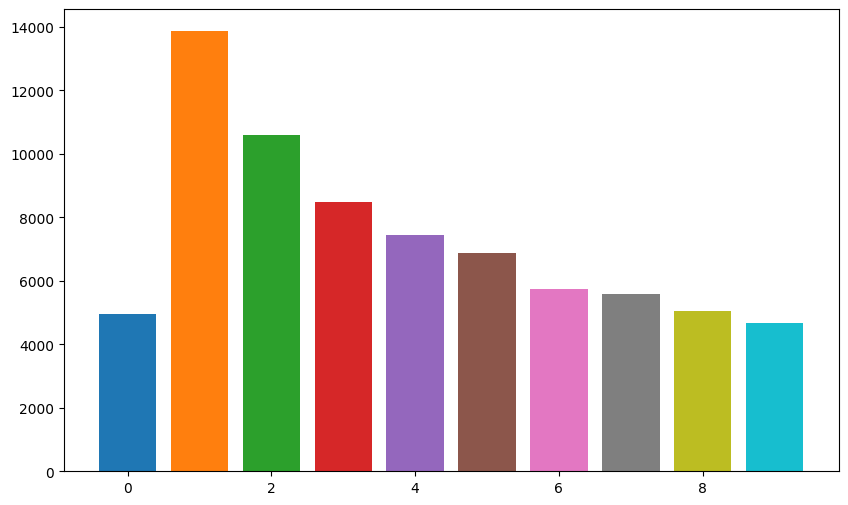

In [131]:
target_distribution(train_labels)

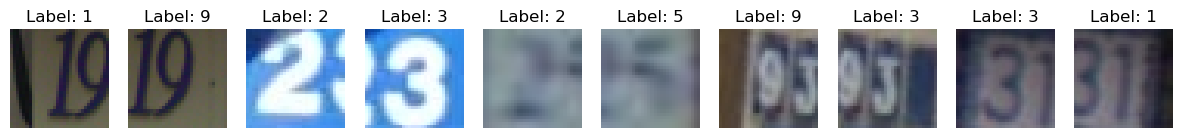

In [4]:
def plot_images(X, y, n=10):
    fig, axes = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        axes[i].imshow(X[:,:,:,i])
        axes[i].set_title(f'Label: {y[i][0]}')
        axes[i].axis('off')
    plt.show()

plot_images(train_data, train_labels)

####  Analyze brightness by computing the mean intensity of all images

In [133]:
grayscale_images = 0.2989 * train_data[:, :, 0, :] + 0.5870 * train_data[:, :, 1, :] + 0.1140 * train_data[:, :, 2, :]
mean_brightness = np.mean(grayscale_images)

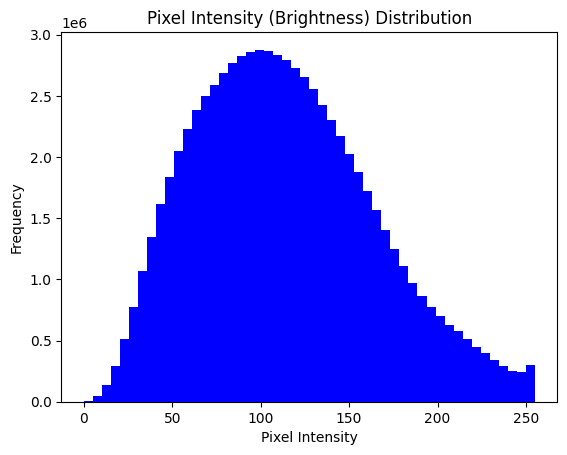

In [134]:
# Brightness Histogram
plt.hist(grayscale_images.ravel(), bins=50, color='blue')
plt.title('Pixel Intensity (Brightness) Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

Histogram: A histogram of brightness values gives a sense of the distribution of brightness across the dataset. We can identify whether most images are well-lit, too dark, or overexposed.

This distribution of brightness suggests that the dataset overall has balanced lighting conditions (normal like distribution), with most pixel intensities centered around mid-level brightness.

The dataset seems to avoid extreme underexposure or overexposure, which is positive for digit recognition tasks. However, the presence of a small spike at 255 (maximum brightness) might indicate that a few images have overly bright regions that could require preprocessing to avoid artifacts or noise in the training process.

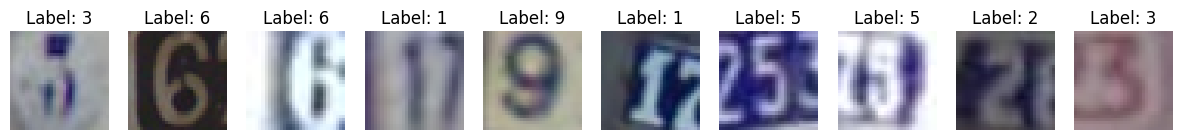

In [135]:
# Random Sample of Images
def plot_random_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        rand_idx = np.random.randint(images.shape[-1])
        #image = np.transpose(images[:, :, :, rand_idx], (1, 0, 2))  # Transpose to match the correct orientation
        image = images[:, :, :, rand_idx]
        label = labels[rand_idx][0]
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Show random images
plot_random_images(train_data, train_labels, 10)

#### Pixel Variability Visualization
We can plot the standard deviation of pixel intensities across a subset of images. This helps identify regions with high variability (likely due to overlapping digits or noise).

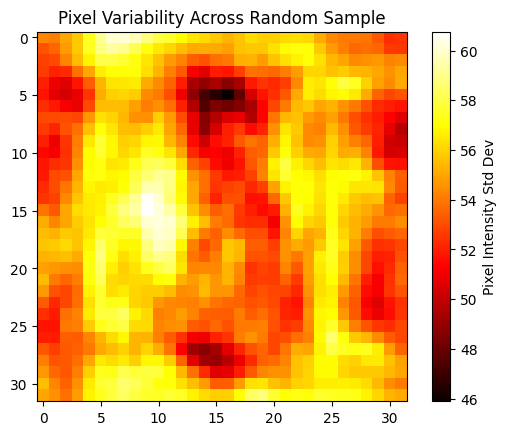

In [136]:
# Compute pixel variability (standard deviation) across a random sample of images
def plot_pixel_variability(images, sample_size=100):
    sample_indices = np.random.choice(images.shape[-1], sample_size, replace=False)
    sampled_images = images[:, :, :, sample_indices]

    # Compute the standard deviation across the sample for each pixel
    pixel_std = np.std(sampled_images, axis=-1)

    # Plot the pixel variability as an image
    plt.imshow(np.mean(pixel_std, axis=2), cmap='hot')
    plt.colorbar(label="Pixel Intensity Std Dev")
    plt.title("Pixel Variability Across Random Sample")
    plt.show()

plot_pixel_variability(train_data, sample_size=100)

Specific Inferences from the Plot:

Bright Yellow Areas (High Std Dev): These areas, with high standard deviations, likely correspond to parts of the images where digits or important features appear in different places across the images.
Interpretation: These regions could indicate the varying presence of digits or other features that are not consistently aligned across the dataset. If digits are not centered, or if their shapes vary significantly, this would result in a higher pixel variability in these regions.

Darker Red and Black Areas (Low Std Dev): The darker regions indicate more consistent pixel intensities across the sample of images.

Interpretation: These areas likely correspond to the background or other uniform regions in the images that don’t change much across the subset of images. This could also mean these regions consistently contain no digit features (blank or uniform regions).

Potential Causes of Pixel Variability:

Alignment Issues: The high variability suggests that digits are not perfectly centered across all images. Different digit positions will lead to significant variations in pixel intensities.

Varying Image Content: The variability also suggests that different images have very different content (i.e., different digits or numbers with multiple digits appearing at different places).

Image Noise or Artifacts: The dataset contains noisy images, there are issues with the quality of some images, this introduces variability in the pixel intensities.

Overlapping Digits: The dataset has overlapping digits, the regions where digits overlap show higher pixel variability as the digit edges are less defined or mixed.

#### Heatmap of Average Digit Placement
We can visualize the average intensity values for each class, which gives an indication of where each digit tends to appear in the image. This can highlight potential misalignments or overlapping areas.

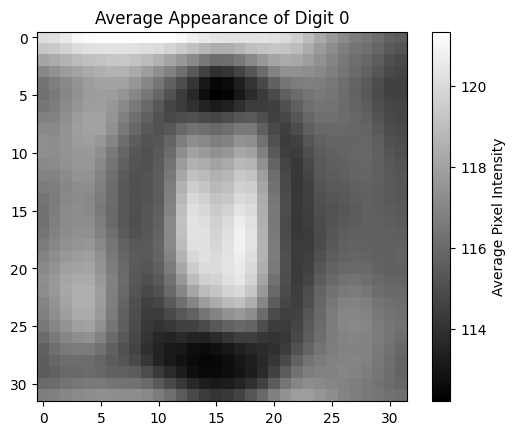

In [137]:
def plot_average_digit(images, labels, digit):
    # Filter the images corresponding to the given digit
    digit_images = images[:, :, :, labels.flatten() == digit]

    # Compute the average intensity of the images for the selected digit
    average_digit = np.mean(digit_images, axis=-1)

    # Plot the average image
    plt.imshow(np.mean(average_digit, axis=2), cmap='gray')
    plt.title(f'Average Appearance of Digit {digit}')
    plt.colorbar(label="Average Pixel Intensity")
    plt.show()

# Example: Plot average appearance for digit 0
plot_average_digit(train_data, train_labels, digit=0)

#### Histogram of Pixel Intensity Distribution for Overlapping Regions
If overlapping digits are suspected, we can analyze the pixel intensity distribution for regions where overlapping is likely (centered around the image).

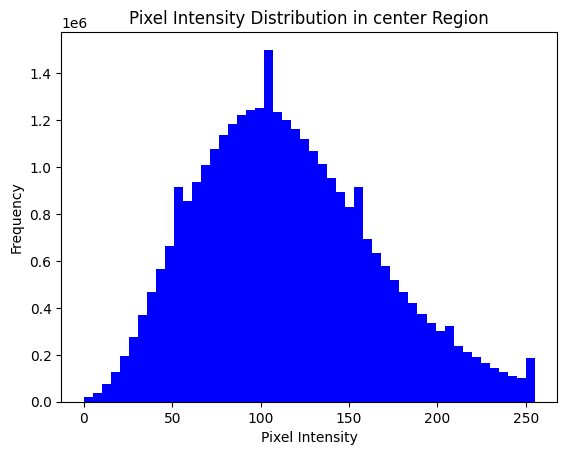

In [138]:
def plot_intensity_distribution(images, region='center'):
    # Extract a region of interest (center region likely to have overlapping digits)
    if region == 'center':
        cropped_images = images[10:22, 10:22, :, :]  # Example: central 12x12 pixels
    else:
        cropped_images = images  # Use full image if not focused on any region

    # Plot the pixel intensity distribution for the region
    plt.hist(cropped_images.ravel(), bins=50, color='blue')
    plt.title(f'Pixel Intensity Distribution in {region} Region')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Example: Intensity distribution for the center region
plot_intensity_distribution(train_data, region='center')

The pixel intensity distribution in the center region suggests the following:

There is a high likelihood of overlapping digits in the center, as indicated by the peak in mid-level intensities.

There are potential issues with brightness and contrast, as suggested by the spikes at the extreme ends of the intensity range (0 and 255).

The overall variability in pixel intensities indicates that the central region of the images may contain important features like digit overlaps, noise, or artifacts that could affect model performance if not properly addressed.

#### Side-by-Side Comparison of Different Digits
To visually inspect differences in how digits are represented, we can plot a grid of images from different digit classes to spot potential misalignments or overlapping patterns.

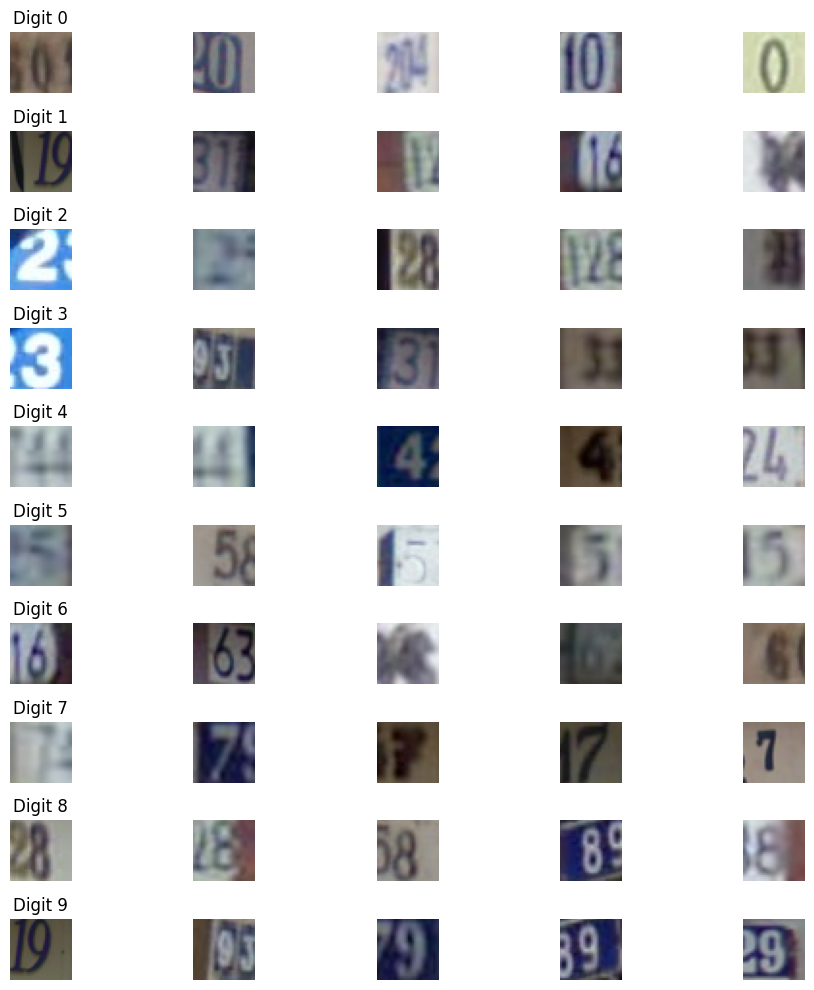

In [139]:
def plot_digits_grid(images, labels, digits=[0, 1, 2, 3], samples_per_digit=5):
    fig, axes = plt.subplots(len(digits), samples_per_digit, figsize=(10, 10))

    for i, digit in enumerate(digits):
        digit_images = images[:, :, :, labels.flatten() == digit]
        for j in range(samples_per_digit):
            axes[i, j].imshow(digit_images[:, :, :, j])
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'Digit {digit}')

    plt.tight_layout()
    plt.show()

# Example: Plot 5 samples for digits 0, 1, 2, and 3
plot_digits_grid(train_data, train_labels, digits=[0, 1, 2, 3, 4, 5 ,6, 7, 8, 9], samples_per_digit=5)

#### Edge Detection to Highlight Noise (Sobel Filter)
Noise often leads to random, high-frequency variations in the pixel intensities, which can be detected using edge detection techniques like the Sobel filter.

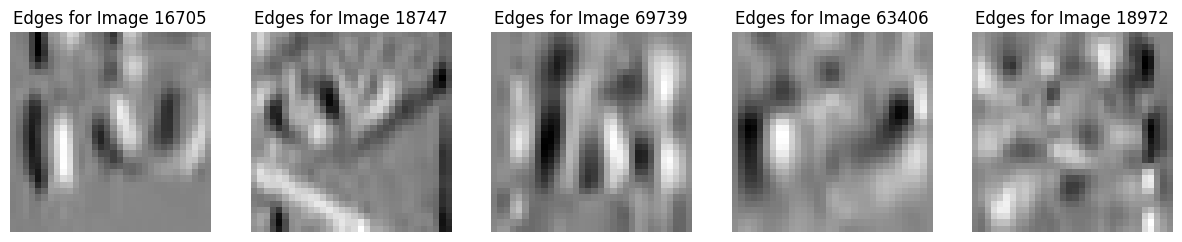

In [141]:
from scipy.ndimage import sobel

# Function to apply Sobel filter and detect edges
def plot_sobel_edges(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    for i in range(num_images):
        rand_idx = np.random.randint(images.shape[-1])
        image = np.transpose(images[:, :, :, rand_idx], (1, 0, 2))

        # Convert image to grayscale for edge detection
        grayscale_image = 0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2]

        # Apply Sobel filter to detect edges
        edges = sobel(grayscale_image)

        axes[i].imshow(edges, cmap='gray')
        axes[i].set_title(f'Edges for Image {rand_idx}')
        axes[i].axis('off')

    plt.show()

# Detect edges using Sobel filter
plot_sobel_edges(train_data, num_images=5)

The Sobel filter results suggest that some images in the SVHN dataset suffer from noise, blurriness, or poor contrast, which could obscure the edges of the digits and make recognition difficult.

In several of the images (particularly 68361, 62238, and 53874), the Sobel filter detects noise or edges in regions that are likely to be part of the background, not the digits. This suggests that the dataset contains some background noise, which may interfere with digit recognition.

Some images (like 70547 and 15836) show weak or blurry edges, suggesting that either the digits are not clearly separated from the background, or the images themselves are of poor quality.

#### Laplacian Variance for Blurriness Detection
The Laplacian variance method detects blurriness by measuring how much the image is lacking in high-frequency details. Lower variance indicates higher blurriness.

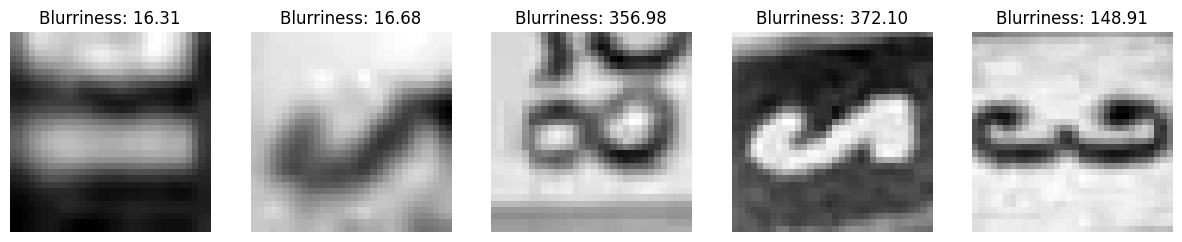

In [142]:
# Function to compute Laplacian variance and plot blurriness
def plot_blurriness(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    for i in range(num_images):
        rand_idx = np.random.randint(images.shape[-1])
        image = np.transpose(images[:, :, :, rand_idx], (1, 0, 2))

        # Convert image to grayscale for blurriness detection
        grayscale_image = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_RGB2GRAY)

        # Compute Laplacian variance
        laplacian_var = cv2.Laplacian(grayscale_image, cv2.CV_64F).var()

        axes[i].imshow(grayscale_image, cmap='gray')
        axes[i].set_title(f'Blurriness: {laplacian_var:.2f}')
        axes[i].axis('off')

    plt.show()

# Analyze blurriness in images
plot_blurriness(train_data, num_images=5)

The presence of images with both high and low blurriness scores suggests that the SVHN dataset contains a mixture of sharp and blurry images. This could introduce variability into the dataset, affecting model performance.

In [143]:
def set_seed(seed):
    """ Set all seeds to make results reproducible (deterministic mode). """
    #random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [144]:
set_seed(42)

In [146]:
# Define a lightweight CNN model with depthwise separable convolutions
class MobileNetCNN(nn.Module):
    def __init__(self):
        super(MobileNetCNN, self).__init__()
        # Define depthwise separable convolution
        def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, padding=padding),
                nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )

        # Use depthwise separable convolutions
        self.conv1 = depthwise_separable_conv(3, 16)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = depthwise_separable_conv(16, 32)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 8 * 8, 64)  # Smaller fully connected layer
        self.fc2 = nn.Linear(64, 10)  # 10 classes for digits

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Apply depthwise separable convolutions with pooling and batch normalization
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

       # Flatten the tensor to pass it into the fully connected layer
        x = x.view(x.size(0), -1)  # Flattening, dynamically calculate the size
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.dropout(x)
        x = self.fc2(x)
        #print(x.shape)
        return x

# Initialize and print model summary
model = MobileNetCNN()
print(model)


MobileNetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
    (1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
    (1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [147]:
# Normalize the pixel values to the range [0, 1]
def normalize_images(images):
    return images / 255.0

# Define data augmentation transforms
transform = transforms.Compose([
    transforms.ToPILImage(),           # Convert to PIL image for torchvision transforms
    transforms.RandomRotation(15),     # Random rotation
    transforms.RandomHorizontalFlip(), # Horizontal flip
    transforms.ToTensor(),             # Convert back to Tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize with mean 0.5 and std 0.5
])

In [148]:
train_data.shape

(32, 32, 3, 73257)

In [172]:
test_data.shape

(32, 32, 3, 26032)

In [149]:
# Step 3: Convert SVHN Data into PyTorch Tensors
X = torch.tensor(normalize_images(train_data), dtype=torch.float32).permute(3, 2, 0, 1)
y = torch.tensor(train_labels.flatten(), dtype=torch.long)

In [173]:
X_test = torch.tensor(normalize_images(test_data), dtype=torch.float32).permute(3, 2, 0, 1)
y_test = torch.tensor(test_labels.flatten(), dtype=torch.long)

In [150]:
X.shape

torch.Size([73257, 3, 32, 32])

In [151]:
X_train, X_val, y_train, y_val = train_test_split(X,y,stratify=y,test_size=0.10,random_state=42)

In [174]:
# Double-check sizes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_val shape: {y_test.shape}")

X_train shape: torch.Size([65931, 3, 32, 32]), y_train shape: torch.Size([65931])
X_val shape: torch.Size([7326, 3, 32, 32]), y_val shape: torch.Size([7326])
X_test shape: torch.Size([26032, 3, 32, 32]), y_val shape: torch.Size([26032])


In [153]:
# Create a custom dataset class to apply transforms
class SVHNDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].numpy().transpose(1, 2, 0)  # Convert back to HWC format for PIL
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [176]:
# Apply transforms and create datasets
train_dataset = SVHNDataset(X_train, y_train, transform=transform)
val_dataset = SVHNDataset(X_val, y_val, transform=transform)
test_dataset = SVHNDataset(X_test, y_test, transform=transform)

In [177]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

65931 7326 26032


In [156]:
# Step 4: Create DataLoaders for Efficient Data Loading
batch_size = 64

train_loader=DataLoader(train_dataset,
                       sampler=RandomSampler(train_dataset),
                       batch_size=batch_size,
                       drop_last=True
                       )

val_loader=DataLoader(val_dataset,
                      sampler=SequentialSampler(val_dataset),
                      batch_size=batch_size,
                      )

In [178]:
test_loader=DataLoader(test_dataset,
                      sampler=SequentialSampler(test_dataset),
                      batch_size=batch_size,
                      )

In [157]:
def format_time(elapsed):
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [168]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            #print(images.shape, labels.shape)
            # Ensure images and labels have the same batch size
            assert images.size(0) == labels.size(0), f"Batch size mismatch: {images.size(0)} != {labels.size(0)}"

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            #print(outputs.shape, labels.shape)
            loss = criterion(outputs.squeeze(0), labels)

            # Backward pass and optimize
            loss.backward()

            # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        validate_model()

In [160]:
def validate_model():
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    total_loss= 0
    # empty list to save the model predictions
    total_preds = []
    val_labels = []
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs.squeeze(0), labels)
            #print(loss)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_preds.append(predicted)
            val_labels.append(labels)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_loader)
    print(f'Validation loss: {avg_loss:.2f}')
    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

In [181]:
def test_model():
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    total_loss= 0
    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_preds.append(predicted)
            total_labels.append(labels)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    total_preds  = np.concatenate(total_preds, axis=0)
    total_labels  = np.concatenate(total_labels, axis=0)
    return total_preds, total_labels

In [163]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [164]:
torch.unique(y_train)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [169]:
#compute the class weights
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=np.array(y_train))

print("Class Weights:",class_weights)
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to device
weights = weights.to(device)

Class Weights: [1.48059735 0.52850501 0.69211631 0.86218125 0.98228546 1.06443332
 1.27922002 1.3091938  1.45190487 1.57240639]


In [170]:
# Step 7: Initialize the Model, Criterion, Optimizer, and Train
model = MobileNetCNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [171]:
train_model(model, train_loader, criterion, optimizer, num_epochs=30, device=device)

Epoch [1/30], Loss: 2.2214
Validation loss: 1.98
Validation Accuracy: 32.31%
Epoch [2/30], Loss: 1.8025
Validation loss: 1.68
Validation Accuracy: 40.40%
Epoch [3/30], Loss: 1.6456
Validation loss: 1.59
Validation Accuracy: 42.67%
Epoch [4/30], Loss: 1.5825
Validation loss: 1.53
Validation Accuracy: 43.97%
Epoch [5/30], Loss: 1.5339
Validation loss: 1.51
Validation Accuracy: 45.11%
Epoch [6/30], Loss: 1.4262
Validation loss: 1.23
Validation Accuracy: 59.40%
Epoch [7/30], Loss: 1.1801
Validation loss: 1.04
Validation Accuracy: 66.52%
Epoch [8/30], Loss: 1.0258
Validation loss: 1.00
Validation Accuracy: 68.32%
Epoch [9/30], Loss: 0.9819
Validation loss: 1.02
Validation Accuracy: 68.55%
Epoch [10/30], Loss: 0.9570
Validation loss: 0.94
Validation Accuracy: 70.64%
Epoch [11/30], Loss: 0.9421
Validation loss: 0.93
Validation Accuracy: 69.93%
Epoch [12/30], Loss: 0.9272
Validation loss: 0.98
Validation Accuracy: 70.08%
Epoch [13/30], Loss: 0.9040
Validation loss: 0.87
Validation Accuracy: 71

In [ ]:
epochs=5

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss = train_model()

    #validate model
    valid_loss = validate_model()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

print("Training completed")

print("Total training time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# push the model to CPU
model = model.to(device)

In [182]:
# Evaluate the model
preds, labels = test_model()

Test Accuracy: 73.99%


In [183]:
np.array(labels).shape

(26032,)

In [184]:
classification_report(np.array(labels),np.array(preds))

'              precision    recall  f1-score   support\n\n           0       0.74      0.81      0.77      1744\n           1       0.86      0.85      0.86      5099\n           2       0.80      0.77      0.79      4149\n           3       0.63      0.59      0.61      2882\n           4       0.75      0.80      0.78      2523\n           5       0.62      0.72      0.66      2384\n           6       0.66      0.58      0.62      1977\n           7       0.75      0.79      0.77      2019\n           8       0.70      0.60      0.64      1660\n           9       0.68      0.70      0.69      1595\n\n    accuracy                           0.74     26032\n   macro avg       0.72      0.72      0.72     26032\nweighted avg       0.74      0.74      0.74     26032\n'

In [185]:
precision_recall_fscore_support(np.array(labels),np.array(preds), average='macro')

(0.7200656068888651, 0.7222971153662265, 0.7197847810774525, None)

In [186]:
precision_recall_fscore_support(np.array(labels),np.array(preds), average='micro')

(0.7399354640442533, 0.7399354640442533, 0.7399354640442533, None)

In [187]:
precision_recall_fscore_support(np.array(labels),np.array(preds), average='weighted')

(0.7403370220257675, 0.7399354640442533, 0.739024230376561, None)